In [2]:
from matplotlib import pyplot
import matplotlib
import pandas
from CO2_data_collector import CO2DataCollector
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
import CO2_pre_processing as pre
from pylab import rcParams
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import numpy
from statsmodels.tsa.stattools import adfuller

# Collect the data
In this section we show how to collect the emissions data for a given time period

In [3]:
collector = CO2DataCollector()

In [4]:
# Collects the data between two boundaries dates
collector.collect_data('2017-01-01', '2020-01-01')

In [5]:
# Generates a CSV file with the collected data
collector.generate_csv('Emissions_2018-2020.csv')

# Data Cleaning
In this section we will perform some data cleaning since there are some corrupted data
that needs to be cleaned to convert the Fecha's column from string to a datetime object

In [2]:
dataset = pandas.read_csv('Emissions_2018-2020.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157680 entries, 0 to 157679
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  157680 non-null  int64  
 1   Fecha       157680 non-null  object 
 2   Emisiones   157680 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.6+ MB


Is there a problem with the data, on certain dates on the interval from 02 to 03, where there are corrupted hours like the following ones:
- 2019-10-27 2A:00
- 2019-10-27 2A:10
- 2019-10-27 2A:20
- 2019-10-27 2A:30
- 2019-10-27 2A:40
- 2019-10-27 2A:50
- 2019-10-27 2B:00
- 2019-10-27 2B:10
- 2019-10-27 2B:20
- 2019-10-27 2B:30
- 2019-10-27 2B:40
- 2019-10-27 2B:50

**Solution:**
- Drop rows which contain the letter 'B' in the Fecha's column
- In the rows where the date contains the characters 2A, replace these with 02

In [4]:
dataset.head()

,Unnamed: 0,Fecha,Emisiones
0,0,2016-12-31 21:00,9659.81
1,1,2016-12-31 21:10,9627.94
2,2,2016-12-31 22:30,9407.57
3,3,2016-12-31 21:20,9562.48
4,4,2016-12-31 21:30,9545.36


In [5]:
# Drop the Unnamed: 0 column
if 'Unnamed: 0' in dataset.columns:
    dataset = dataset.drop(['Unnamed: 0'], axis=1)

In [6]:
# Replace dates with 2A by 02
dataset['Fecha'] = dataset['Fecha'].str.replace('2A', '02')
# Use the NOT simbol (~) to return the dataset without these rows
dataset = dataset[~dataset.Fecha.str.contains("2B")]

In [7]:
dataset.head(10)

,Fecha,Emisiones
0,2016-12-31 21:00,9659.81
1,2016-12-31 21:10,9627.94
2,2016-12-31 22:30,9407.57
3,2016-12-31 21:20,9562.48
4,2016-12-31 21:30,9545.36
5,2016-12-31 21:50,9442.41
6,2016-12-31 22:10,9514.21
7,2016-12-31 21:40,9494.49
8,2016-12-31 22:20,9448.20
9,2016-12-31 22:00,9420.89


As we can see the dataset is unordered, so in order to sort it we must perform the following tasks:
- Convert the Datetime column 'Fecha' to a datetime object
- Set the Datetime column as the Index
- Sort the dataset by index

In [8]:
# Converts 'Fecha' to datetime object
dataset['Fecha'] = pandas.to_datetime(dataset['Fecha'])
# Sets the 'Fecha' column as index
dataset = dataset.set_index('Fecha')
# Sort the dataset by index
dataset = dataset.sort_index()

In [9]:
dataset.head()

,Emisiones
Fecha,
2016-12-31 21:00:00,9659.81
2016-12-31 21:10:00,9627.94
2016-12-31 21:20:00,9562.48
2016-12-31 21:30:00,9545.36
2016-12-31 21:40:00,9494.49


## Creation of alternative dataset
We will create an alternative dataset where the difference between timestamps is one hour, so the emissions will be grouped by hours

In [10]:
# Cretes the new dataset
dataset_freq_1hour = pre.create_dataset_timefreq_1hour(dataset)

In [11]:
dataset_freq_1hour.head(10)

,Fecha,Emisiones
0,2016-12-31 21:00:00,57332.49
1,2016-12-31 22:00:00,56671.33
2,2016-12-31 23:00:00,57666.70
3,2017-01-01 00:00:00,57684.04
4,2017-01-01 01:00:00,56670.97
5,2017-01-01 02:00:00,53940.48
6,2017-01-01 03:00:00,51843.22
7,2017-01-01 04:00:00,50390.88
8,2017-01-01 05:00:00,49331.71
9,2017-01-01 06:00:00,48633.39


## CSV Creation
Now we will create two csv files to store the cleaned dataset. In the first dataset, the difference between timestamps is one hour, while in the second the difference is ten minutes

In [17]:
dataset.head()

,Emisiones
Fecha,
2016-12-31 21:00:00,9659.81
2016-12-31 21:10:00,9627.94
2016-12-31 21:20:00,9562.48
2016-12-31 21:30:00,9545.36
2016-12-31 21:40:00,9494.49


**Creates 1 hour difference CSV**

In [13]:
# Creates a new CSV with no data errors and ordered rows by date
dataset_freq_1hour.to_csv("2017-2020_Emissions_by_hour_Clean.csv", index=False)

**Creates 10 minutes difference CSV**

In [14]:
# Creates a new CSV with no data errors and ordered rows by date
dataset.to_csv("2017-2020_Emissions_by_10_minutes_Clean.csv")

# Data Analysis

In [16]:
# Read both csv files
dataset_by_10_minutes = pandas.read_csv('2017-2020_Emissions_by_10_minutes_Clean.csv')
dataset_by_hour = pandas.read_csv('2017-2020_Emissions_by_hour_Clean.csv')

CSV files cannot cannot save datetime objects and saves the rows unordered, so each time we read a CSV file, we must
to perform the following tasks:
- Convert 'Fecha' column to datetime object
- Set 'Fecha' column as the new index
- Sort the dataset by DateTime Index

In [18]:
# This function perform the tasks above
dataset_by_10_minutes = pre.prepare_timeseries_dataset(dataset_by_10_minutes, 0)
dataset_by_hour = pre.prepare_timeseries_dataset(dataset_by_hour, 0)

In [20]:
dataset_by_10_minutes.head(10)

,Emisiones
Fecha,
2016-12-31 21:00:00,9659.81
2016-12-31 21:10:00,9627.94
2016-12-31 21:20:00,9562.48
2016-12-31 21:30:00,9545.36
2016-12-31 21:40:00,9494.49
2016-12-31 21:50:00,9442.41
2016-12-31 22:00:00,9420.89
2016-12-31 22:10:00,9514.21
2016-12-31 22:20:00,9448.20


In [21]:
dataset_by_hour.head(10)

,Emisiones
Fecha,
2016-12-31 21:00:00,57332.49
2016-12-31 22:00:00,56671.33
2016-12-31 23:00:00,57666.70
2017-01-01 00:00:00,57684.04
2017-01-01 01:00:00,56670.97
2017-01-01 02:00:00,53940.48
2017-01-01 03:00:00,51843.22
2017-01-01 04:00:00,50390.88
2017-01-01 05:00:00,49331.71


## Resample the dataset
In this section we will try to resample the dataset in order to obtain the mean of emissions for each month and decompose it to analyze
the trend and seasonality

In [7]:
dataset_by_hour.index

DatetimeIndex(['2016-12-31 21:00:00', '2016-12-31 22:00:00',
               '2016-12-31 23:00:00', '2017-01-01 00:00:00',
               '2017-01-01 01:00:00', '2017-01-01 02:00:00',
               '2017-01-01 03:00:00', '2017-01-01 04:00:00',
               '2017-01-01 05:00:00', '2017-01-01 06:00:00',
               ...
               '2019-12-31 11:00:00', '2019-12-31 12:00:00',
               '2019-12-31 13:00:00', '2019-12-31 14:00:00',
               '2019-12-31 15:00:00', '2019-12-31 16:00:00',
               '2019-12-31 17:00:00', '2019-12-31 18:00:00',
               '2019-12-31 19:00:00', '2019-12-31 20:00:00'],
              dtype='datetime64[ns]', name='Fecha', length=26276, freq=None)

If we look the frequency of our dataset, it is set to None, so we will have to infer it in order to resample the dataset

In [24]:
# Converts the dataset into a frequency of 1 hour, it doesn't change the data because it already have a frequency of 1 hour
dataset_by_hour = dataset_by_hour.asfreq('H')

### Check and handle missing values

In [32]:
dataset_by_hour.isnull().sum()

Emisiones    0
dtype: int64

Due to setting the frequency, 4 missing values have been created so we will use interpolation to handle them

In [31]:
dataset_by_hour = dataset_by_hour.interpolate()

Now we will try to resample the dataset to a monthly frequency and the mean of emissions

In [26]:
dataset_by_month = dataset_by_hour['Emisiones'].resample('MS').mean()

In [27]:
dataset_by_month.head(10)

Fecha
2016-12-01    57223.506667
2017-01-01    61563.583347
2017-02-01    46414.701845
2017-03-01    29037.953513
2017-04-01    24765.413931
2017-05-01    38081.439140
2017-06-01    50720.670472
2017-07-01    49045.904637
2017-08-01    39786.750027
2017-09-01    40026.869500
Freq: MS, Name: Emisiones, dtype: float64

In [25]:
# Check if some missing values have been created because of resampling
dataset_by_month.isnull().sum()

0

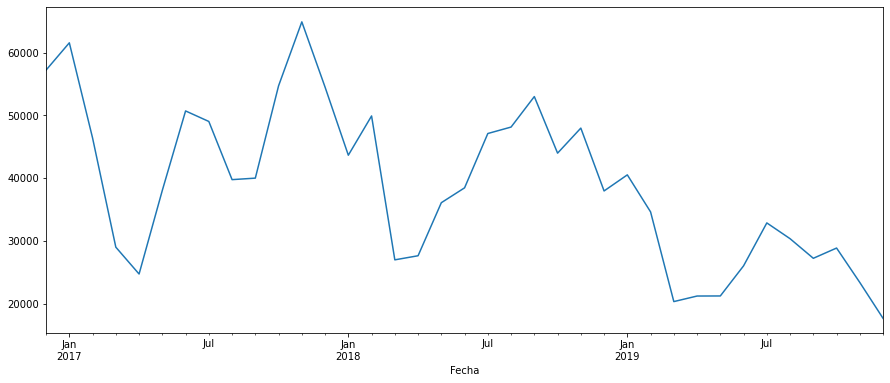

In [24]:
dataset_by_month.plot(figsize=(15, 6))
pyplot.show()

Looking the data we can form some hypotheses:
- It has a decreasing trend, maybe caused by some energy related politics which improve the use of renovables energies through the years
- It shows a seasonality pattern, from January to April emissions decrease greatly, then from April to December they increases to the peak but with some decreasing in September or October.

## Decompose the series

Now we will decompose the series into an additive or multiplicative series.

**Additive Series:**
Value = Base Level + Trend + Seasonality + Error

**Multiplicative Series:**
Value = Base Level * Trend * Seasonality * Error

It seems that the dataset is a multiplicative series because of it seems to be non-linear, the seasonality has different frequency and amplitude over time, we will plot both models and confirm this hypotheses

In [26]:
## If our dataset would not have a specific frequency, we would have to add the period parameter.
# Multiplicative Decomposition
result_mul = seasonal_decompose(dataset_by_month, model='multiplicative')
# Additive Decomposition
result_add = seasonal_decompose(dataset_by_month, model='additive')

In [33]:
# Set the figsize
rcParams['figure.figsize'] = 11, 11

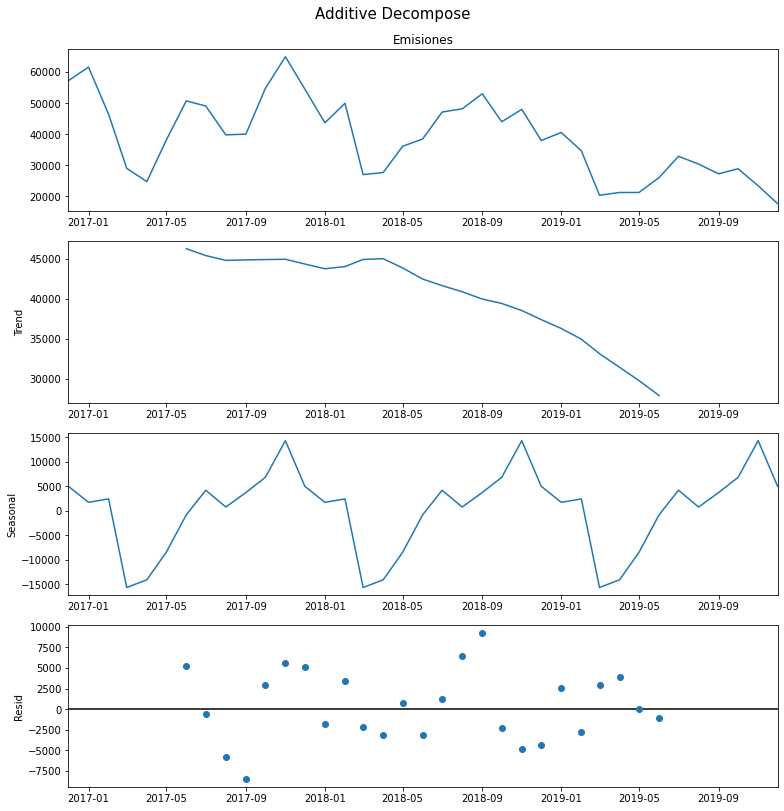

In [38]:
# Plot additive decomposition
result_add.plot().suptitle('Additive Decompose', fontsize=15, y=1.02)
pyplot.show()

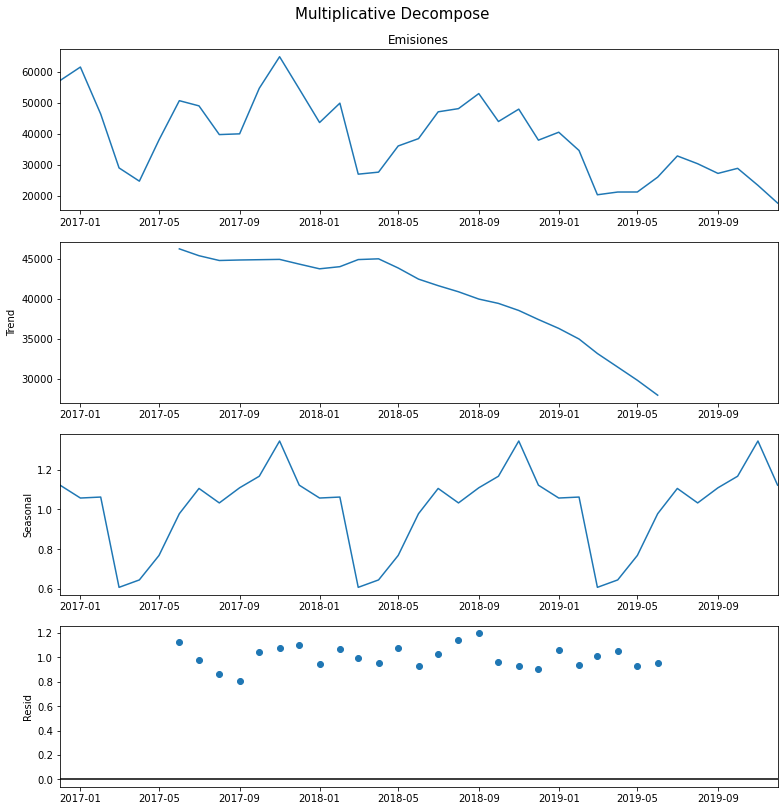

In [39]:
# Plot multiplicative decomposition
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=15, y=1.02)
pyplot.show()

## Stationary Test (Dickey-Fuller Test)
The Dickey-Fuller Test is a type of unit root test. The intuition vehind is that it determines how strongly a time series is defined by a trend.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

   **Null Hypothesis (H0):** If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

   **Alternate Hypothesis (H1):** The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
   
The output is an ADF value and a p-value. The ADF number should be a negative number and the p-value should be beneath a certain threshold value (e.g., 1% or 5%, etc) for a confidence level. For this example, we’ll use 5% (or 95% confidence level), so:

If the **p-value > 0.05**: Fail to reject the null hypothesis because the data has a unit root and is non-stationary.

If the **p-value <= 0.05**: Reject the null hypothesis because the data does not have a unit root and is stationary. 

Also, we have to compare the ADF value with the critical values for 99%, 90% and 95% confidence levels

In [22]:
dataset_by_hour.isnull().sum()

Emisiones    0
dtype: int64

In [30]:
# Apply the test on series values
test_result = adfuller(dataset_by_month)

# Output the results
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.204116
p-value: 0.204755
Critical Values:
	1%: -3.627
	5%: -2.946
	10%: -2.612


The output shows a p-value greater than 0.05 and the ADF value is greater than the 1% confidence value of -3.627, so we fail to reject the Null Hypothesis, it is non-stationary

### Transformations

Now we will apply some transformations to the data in order to apply the test again and see if it is stationary

**Square Root Transform**

**Logarithm Transform**

# Prophet model
In this section we will apply different prophet models to two different dataset: The first is non-stationary and the second one is stationary

## Create the datasets
In order to apply Prophet to a dataset, it must have two specific columns names:
- 'ds' which are the timestamps
- 'y' which are the values
So we must rename 'Fecha' to 'ds' and 'Emisiones' to 'y'

**Creation of the non-stationary dataset**

In [10]:
# Create the dataset
prophet_dataset = dataset_by_hour

# Reset the index in order to be able to rename te columns
prophet_dataset = prophet_dataset.reset_index()
prophet_dataset = prophet_dataset.rename(columns={"Fecha": "ds", "Emisiones": "y"})

prophet_dataset.head()

,ds,y
0,2016-12-31 21:00:00,57332.49
1,2016-12-31 22:00:00,56671.33
2,2016-12-31 23:00:00,57666.70
3,2017-01-01 00:00:00,57684.04
4,2017-01-01 01:00:00,56670.97


**Creation of the stationary dataset**

To create it we must apply a logarithm transformation to the 'Emisiones' column, which is renamed as y

In [11]:
# Create the dataset
prophet_dataset_log = prophet_dataset
# Apply log transformation to have a normal distribution
prophet_dataset_log['y'] = numpy.log(prophet_dataset_log['y'])

prophet_dataset_log.head()

,ds,y
0,2016-12-31 21:00:00,10.956623
1,2016-12-31 22:00:00,10.945024
2,2016-12-31 23:00:00,10.962435
3,2017-01-01 00:00:00,10.962736
4,2017-01-01 01:00:00,10.945017


## Fit the models
We must create two kinds of models:
- A model which fit additive timeseries
- A model which fit multiplicative timeseries

In [12]:
# Create the additive model
prophet_additive = Prophet()
# Create the multiplicative model
prophet_multiplicative = Prophet(seasonality_mode='multiplicative')

We will fit the additive model with the stationary data and the multiplicative model with the non-stationary data

In [13]:
# Fit both models
prophet_additive.fit(prophet_dataset_log)
prophet_multiplicative.fit(prophet_dataset)

Now we create the dates for which to make predictions

In [14]:
future_dates = prophet_additive.make_future_dataframe(periods=24, freq='H')
future_dates.tail()

,ds
26299,2020-01-01 16:00:00
26300,2020-01-01 17:00:00
26301,2020-01-01 18:00:00
26302,2020-01-01 19:00:00
26303,2020-01-01 20:00:00


## Forecast future dates

In [15]:
forecast_additive = prophet_additive.predict(future_dates)
forecast_additive[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
26299,2020-01-01 16:00:00,9.481193,9.191503,9.756266
26300,2020-01-01 17:00:00,9.478541,9.230839,9.754781
26301,2020-01-01 18:00:00,9.497056,9.241187,9.774136
26302,2020-01-01 19:00:00,9.534404,9.250207,9.792877
26303,2020-01-01 20:00:00,9.570939,9.290147,9.848407


In [16]:
forecast_multiplicative = prophet_multiplicative.predict(future_dates)
forecast_multiplicative[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
26299,2020-01-01 16:00:00,9.558886,9.256681,9.852299
26300,2020-01-01 17:00:00,9.557137,9.276388,9.826979
26301,2020-01-01 18:00:00,9.576568,9.305956,9.850869
26302,2020-01-01 19:00:00,9.614520,9.322944,9.876221
26303,2020-01-01 20:00:00,9.651137,9.369674,9.950590


**Plot the additive forecasts**

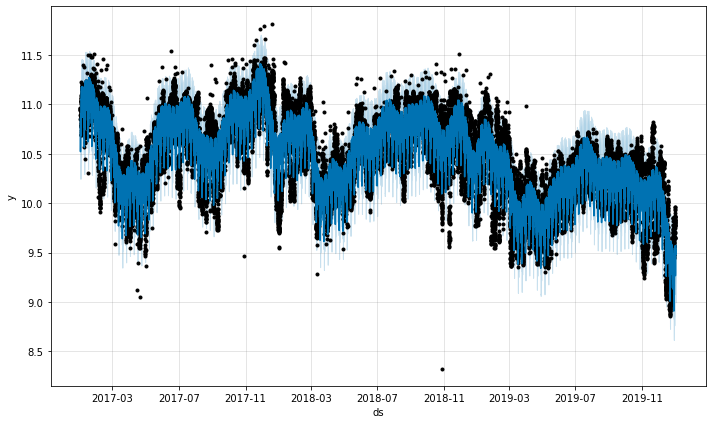

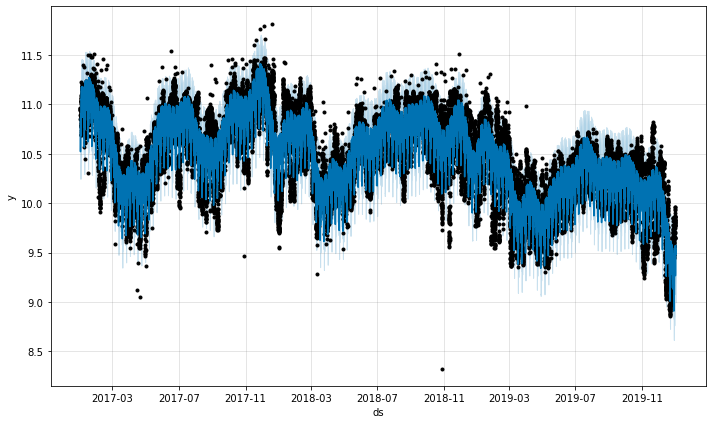

In [17]:
prophet_additive.plot(forecast_additive, uncertainty=True)

**Plot the multiplicative forecasts**

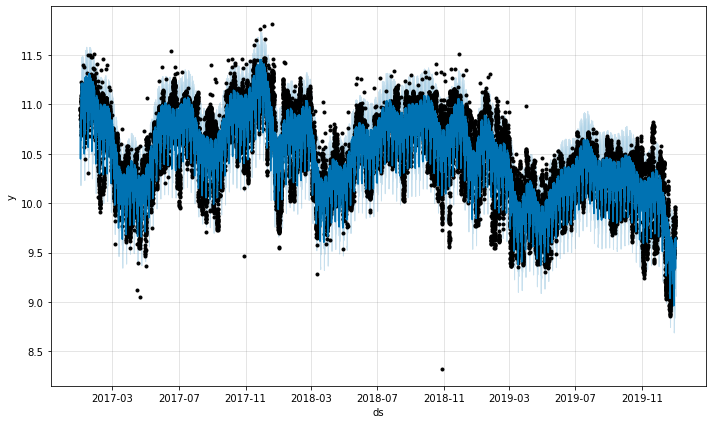

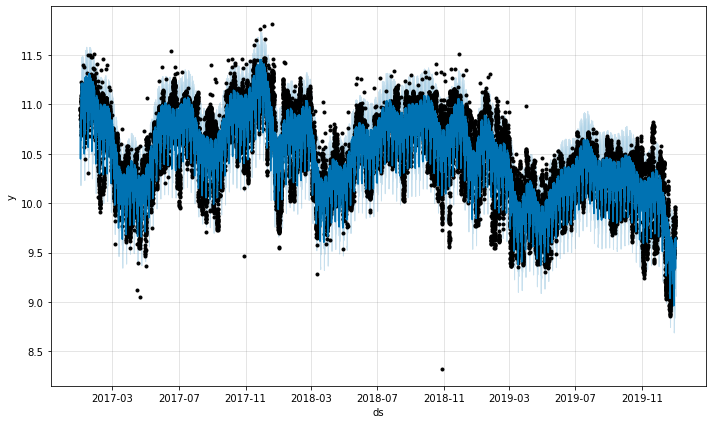

In [18]:
prophet_multiplicative.plot(forecast_multiplicative, uncertainty=True)

## Cross Validation and Perfomance Metrics
We will apply cross validation method and evaluate the perfomance metrics

**CAUTION: This process takes long running**

**Parameters:**
- **initial:** How many days use for train the data, in this case we will use the first 2 years (730 days)
- **period:** Once trained, how often do a prediction, in this case each 90 days
- **horizon:** How much time forecast, in this case 24 hours

In [31]:
df_cv_additive = cross_validation(prophet_additive, initial='730 days', period='90 days', horizon = '24 hours')
df_cv_additive.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-01-04 20:00:00 and 2019-12-30 20:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-04 21:00:00,10.555315,10.279028,10.827584,10.803158,2019-01-04 20:00:00
1,2019-01-04 22:00:00,10.523946,10.251820,10.782652,10.733863,2019-01-04 20:00:00
2,2019-01-04 23:00:00,10.458293,10.196290,10.719199,10.655716,2019-01-04 20:00:00
3,2019-01-05 00:00:00,10.379817,10.108476,10.681854,10.543831,2019-01-04 20:00:00
4,2019-01-05 01:00:00,10.310774,10.029806,10.577093,10.474629,2019-01-04 20:00:00


In [35]:
df_cv_multiplicative = cross_validation(prophet_multiplicative, initial='730 days', period='90 days', horizon = '24 hours')
df_cv_multiplicative.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-01-04 20:00:00 and 2019-12-30 20:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-04 21:00:00,10.583917,10.303468,10.835254,10.803158,2019-01-04 20:00:00
1,2019-01-04 22:00:00,10.546788,10.279594,10.805531,10.733863,2019-01-04 20:00:00
2,2019-01-04 23:00:00,10.471368,10.231112,10.772104,10.655716,2019-01-04 20:00:00
3,2019-01-05 00:00:00,10.381695,10.108373,10.660944,10.543831,2019-01-04 20:00:00
4,2019-01-05 01:00:00,10.302555,10.040661,10.547583,10.474629,2019-01-04 20:00:00


## Compare metrics
In order to compare the metrics we will apply exponential transformation to the additive results so both metrics are in the same scale

In [37]:
# Undo the log transformation to compare metrics in the same scale
df_cv_additive[['yhat', 'yhat_lower', 'yhat_upper', 'y']] = numpy.exp(df_cv_additive[['yhat', 'yhat_lower', 'yhat_upper', 'y']])

additive_metrics = performance_metrics(df_cv_additive)
additive_metrics.head()

AssertionError: 

In [41]:
df_cv_multiplicative[['yhat', 'yhat_lower', 'yhat_upper', 'y']] = numpy.exp(df_cv_multiplicative[['yhat', 'yhat_lower', 'yhat_upper', 'y']])

multiplicative_metrics = performance_metrics(df_cv_multiplicative)
multiplicative_metrics.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,03:00:00,3.199224e+07,5656.168556,5226.904819,0.181315,0.169486,0.800000
1,04:00:00,3.361678e+07,5797.998124,5547.925355,0.219023,0.211482,0.716667
2,05:00:00,3.213772e+07,5669.013604,5436.607585,0.237663,0.195183,0.633333
3,06:00:00,2.818035e+07,5308.516607,5078.774938,0.237342,0.221354,0.600000
4,07:00:00,2.455988e+07,4955.792566,4788.343246,0.229642,0.211087,0.600000


In [43]:
multiplicative_metrics.tail(50)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,0 days 03:00:00,3.199224e+07,5656.168556,5226.904819,0.181315,0.169486,0.800000
1,0 days 04:00:00,3.361678e+07,5797.998124,5547.925355,0.219023,0.211482,0.716667
2,0 days 05:00:00,3.213772e+07,5669.013604,5436.607585,0.237663,0.195183,0.633333
3,0 days 06:00:00,2.818035e+07,5308.516607,5078.774938,0.237342,0.221354,0.600000
4,0 days 07:00:00,2.455988e+07,4955.792566,4788.343246,0.229642,0.211087,0.600000
5,0 days 08:00:00,2.381480e+07,4880.040687,4736.967448,0.230120,0.201780,0.600000
6,0 days 09:00:00,2.627572e+07,5125.984414,4956.017267,0.241078,0.256000,0.600000
7,0 days 10:00:00,2.840452e+07,5329.589340,5138.242017,0.240862,0.212974,0.600000
8,0 days 11:00:00,2.517802e+07,5017.770874,4660.319080,0.200706,0.181469,0.683333
9,0 days 12:00:00,2.202121e+07,4692.675837,3931.877001,0.149231,0.180851,0.766667


Looking both perfomance metrics, they are very similar but Prophet with the multiplicative option seems to perform better on large values

# ARIMA Model
In this section we will implement an ARIMA model to see if it performs better than Prophet

In [5]:
import itertools
import statsmodels.api as sm
pyplot.style.use('fivethirtyeight')

In [6]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


## Grid Search
We will use Grid Search to find the best (p, d, q) values for the series. The model will return the AIC measures, in this case we are interested in the parameters which output the lowest AIC

**IMPORTANT: This takes 3 hours to output all the combinations**

In [20]:
arima_dataset = dataset_by_hour

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(arima_dataset, order=param, seasonal_order=param_seasonal,
                                            enforce_stationarity=False, enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:633414.5534041435
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:617922.4902390288
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:553543.369327063
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:547844.6974175044
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:553239.0489663963
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:548011.2324527923
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:543522.3537183173
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:537873.8818250234
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:614710.5225602345
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:610406.5693869421
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:540071.4191781168
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:535526.467124832
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:537415.3385394595
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:607220.9762419576
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:534370.168653645
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:533219.5452572261
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:508177.5135144641
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:507897.78326784447
ARIMA(0, 1, 

D:\Anaconda\envs\CO2_Project_env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:501736.4989340274
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:506846.8673140489
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:501595.20355398674
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:506049.3003517866
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:507419.4867774888


Looking the outputs, the parameter combination which outputs a lower AIC values are the following:

(p, d, q)(P, D, Q)s = (0, 1, 1) (1, 1, 1, 12)12

## Fitting model
Now we will fit the model with the best parameter combination above

In [21]:
# Creates the model with custom parameters
mod = sm.tsa.statespace.SARIMAX(arima_dataset, order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Train the model with the data
results = mod.fit()

# Output some information
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3077      0.002   -157.820      0.000      -0.312      -0.304
ar.S.L12      -0.2151      0.005    -43.282      0.000      -0.225      -0.205
ma.S.L12      -0.9580      0.001  -1005.360      0.000      -0.960      -0.956
sigma2      1.077e+07   2.74e+04    392.675      0.000    1.07e+07    1.08e+07


From the table above, the 'coef' column show the weight importance of each term an how each one impacts the time series. The The P>|z| column informs us of the significance of each feature weight. 

Here, each weight has a p-value of 0 and none of the term's coefficients is really close to 0, so it is reasonable to retain them in our model.

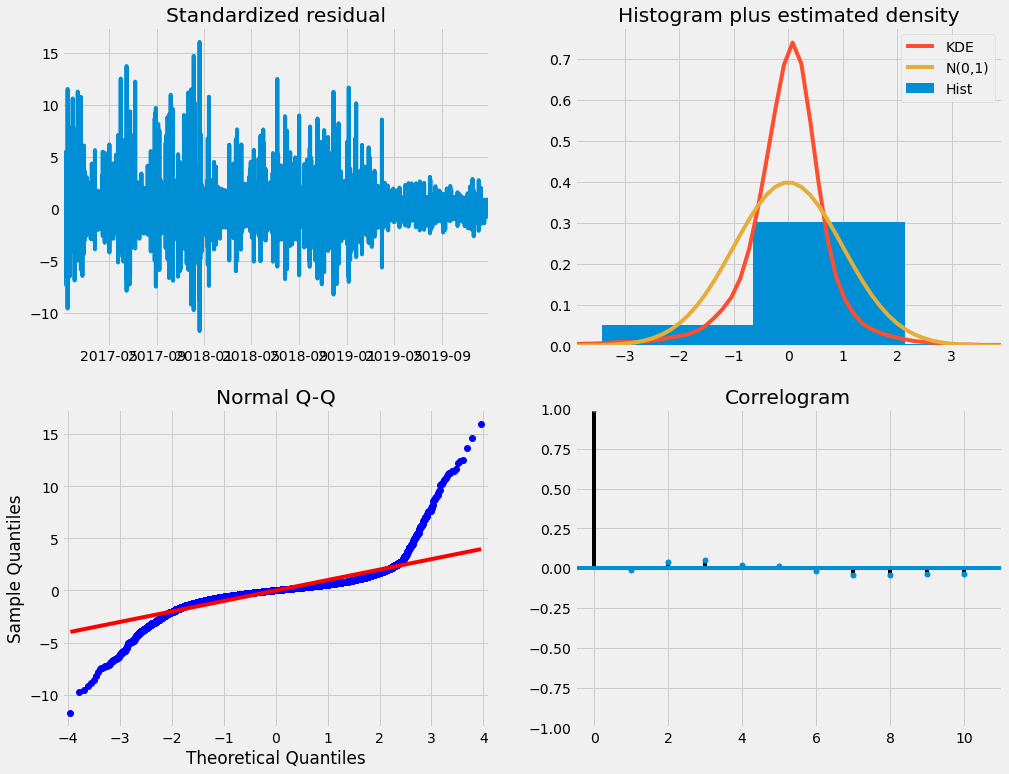

In [23]:
results.plot_diagnostics(figsize=(15, 12))
pyplot.show()

Let's analyze the plots above:
- **Top Left:** The residual error fluctuate around a mean of zero but seems to have a deacreasing trend
- **Top Right:** The density plot doesn't suggest a normal distribution, it seems to be skewed
- **Bottom Left:** Distribution skewed confirmed, otherwise the dots would fall perfectly in line with the red line
- **Bottom Righ:** It shows some autocorrelation

Due to the skewed data, we will have to apply some transformation to it in order to make it stationary

## Validating forecast
We will produce a forecast of a small period in order to validate it and apply the forecast in larger predictions